# Лабораторна робота №2. Реалiзацiя базової архiтектури згорткової нейронної мережi для вирiшення задачi класифiкацiї чи регресiї

**Виконала** студентка групи КІ-41мп Додонова Марія

**Мета:** Навчитися будувати архiтектури простих згорткових нейронних мереж, рiзнi шари (згортка, пулiнг, повнозв’язний), дослiдити налаштування гiпер-параметрiв.

## Порядок виконання

1. Обрати фреймворк для виконання роботи: tensorflow чи pytorch.

2. Обрати простий датасет зображень для вирiшення задачi класифiкацiї чи регресiї. Наприклад, MNIST, Fashion MNIST, Pistachio Image Dataset, Date Fruit Datasets чи iншi.

3. Завантажити, предобробити та роздiлити датасет на тренувальну, валiдацiйну та тестову вибiрки.

4. Обрати базову просту архiтектуру згорткової мережi: LeNet5, AlexNet, ZFNet чи побудувати власну.

5. Реалiзувати вибрану архiтектуру на вибраному фреймворцi з нуля з використанням вбудованих класiв шарiв, оптимiзаторiв та iнше.

6. Навчити мережу на завантаженому датасетi, використовуючи рiзнi гiперпараметри (можливо, але не обов’язково, використати grid search та cross validation).

7. Побудувати графiки навчання (loss та точнiсть) мережi на тренувальнiй та на валiдацiйнiй вибiрках. Проаналiзувати, зробити висновки.


## Виконання роботи

### 1. Обрати фреймворк для виконання роботи: tensorflow чи pytorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [2]:
params = {
    "batch_size": 64,
    "lr": 0.001,
    "epochs": 10
}

### 2. Обрати простий датасет зображень для вирiшення задачi класифiкацiї чи регресiї. Наприклад, MNIST, Fashion MNIST, Pistachio Image Dataset, Date Fruit Datasets чи iншi.

### 3. Завантажити, предобробити та роздiлити датасет на тренувальну, валiдацiйну та тестову вибiрки.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # mean=0.5 and std=0.5
])

train_dataset = datasets.FashionMNIST(
    "..\\data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="..\\data",
    train=False,
    download=True,
    transform=transform
)

train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])

In [4]:
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=2)

### 4. Обрати базову просту архiтектуру згорткової мережi: LeNet5, AlexNet, ZFNet чи побудувати власну.

### 5. Реалiзувати вибрану архiтектуру на вибраному фреймворцi з нуля з використанням вбудованих класiв шарiв, оптимiзаторiв та iнше.

In [5]:
class LeNet(nn.Module):

  def __init__(self):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)

    x = F.relu(self.conv2(x))
    x = self.pool2(x)

    x = torch.flatten(x, 1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [6]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params["lr"])

### 6. Навчити мережу на завантаженому датасетi, використовуючи рiзнi гiперпараметри (можливо, але не обов’язково, використати grid search та cross validation).

In [7]:
def train(model, device="cpu"):
  model = model.to(device)
  model.train()
  running_loss = 0.0
  correct, total = 0, 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_accuracy = correct / total

  return train_loss, train_accuracy


def validate(model, device="cpu"):
  model = model.to(device)
  model.eval()
  running_loss = 0.0
  correct, total = 0, 0

  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)

      running_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_loss = running_loss / len(val_loader)
  val_accuracy = correct / total

  return val_loss, val_accuracy

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

print("Training LeNet:")
for epoch in range(params["epochs"]):
  train_loss, train_accuracy = train(model, device)
  val_loss, val_accuracy = validate(model, device)

  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f"Epoch [{epoch+1}/{params['epochs']}]: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},", \
        f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}.")

print("Finished Training!")

Using device: cuda
Training LeNet:
Epoch [1/10]: Train Loss: 0.6536, Val Loss: 0.4637, Train Accuracy: 0.7587, Val Accuracy: 0.8277.
Epoch [2/10]: Train Loss: 0.4027, Val Loss: 0.3682, Train Accuracy: 0.8518, Val Accuracy: 0.8670.
Epoch [3/10]: Train Loss: 0.3405, Val Loss: 0.3244, Train Accuracy: 0.8745, Val Accuracy: 0.8808.
Epoch [4/10]: Train Loss: 0.3079, Val Loss: 0.3073, Train Accuracy: 0.8866, Val Accuracy: 0.8838.
Epoch [5/10]: Train Loss: 0.2843, Val Loss: 0.3012, Train Accuracy: 0.8944, Val Accuracy: 0.8908.
Epoch [6/10]: Train Loss: 0.2640, Val Loss: 0.3057, Train Accuracy: 0.9023, Val Accuracy: 0.8879.
Epoch [7/10]: Train Loss: 0.2506, Val Loss: 0.2812, Train Accuracy: 0.9061, Val Accuracy: 0.8938.
Epoch [8/10]: Train Loss: 0.2340, Val Loss: 0.2786, Train Accuracy: 0.9127, Val Accuracy: 0.8975.
Epoch [9/10]: Train Loss: 0.2218, Val Loss: 0.2860, Train Accuracy: 0.9172, Val Accuracy: 0.8953.
Epoch [10/10]: Train Loss: 0.2126, Val Loss: 0.2758, Train Accuracy: 0.9190, Val Ac

### 7. Побудувати графiки навчання (loss та точнiсть) мережi на тренувальнiй та на валiдацiйнiй вибiрках. Проаналiзувати, зробити висновки.

In [9]:
def plot():
  plt.figure(figsize=(10, 3))

  # Loss Curve
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.title("Loss Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  # Accuracy Curve
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Train Accuracy")
  plt.plot(val_accuracies, label="Validation Accuracy")
  plt.title("Accuracy Curve")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

  plt.show()

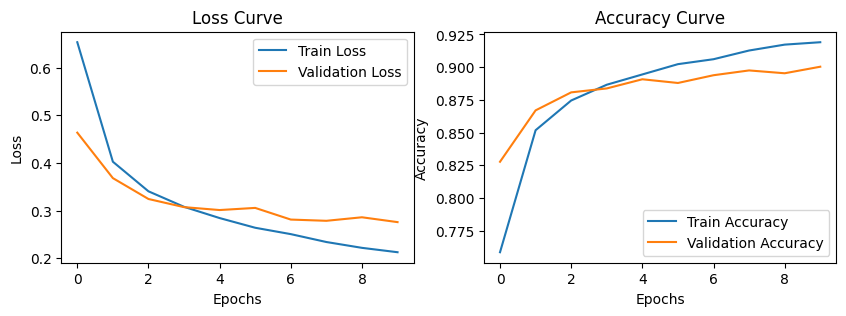

In [10]:
plot()

### [*] 6. Навчити мережу на завантаженому датасетi, використовуючи рiзнi гiперпараметри з використанням grid search.

PARAMETERS: batch_size=32, lr=0.01
Epoch [1/10]: Train Loss: 0.5603, Val Loss: 0.4404, Train Accuracy: 0.7989, Val Accuracy: 0.8381.
Epoch [2/10]: Train Loss: 0.4374, Val Loss: 0.4999, Train Accuracy: 0.8438, Val Accuracy: 0.8469.
Epoch [3/10]: Train Loss: 0.4121, Val Loss: 0.4129, Train Accuracy: 0.8533, Val Accuracy: 0.8569.
Epoch [4/10]: Train Loss: 0.3936, Val Loss: 0.4359, Train Accuracy: 0.8606, Val Accuracy: 0.8583.
Epoch [5/10]: Train Loss: 0.3915, Val Loss: 0.3831, Train Accuracy: 0.8631, Val Accuracy: 0.8691.
Epoch [6/10]: Train Loss: 0.3831, Val Loss: 0.4331, Train Accuracy: 0.8653, Val Accuracy: 0.8468.
Epoch [7/10]: Train Loss: 0.3871, Val Loss: 0.3957, Train Accuracy: 0.8632, Val Accuracy: 0.8629.
Epoch [8/10]: Train Loss: 0.3632, Val Loss: 0.3686, Train Accuracy: 0.8722, Val Accuracy: 0.8728.
Epoch [9/10]: Train Loss: 0.4152, Val Loss: 0.4855, Train Accuracy: 0.8596, Val Accuracy: 0.8312.
Epoch [10/10]: Train Loss: 0.3761, Val Loss: 0.4495, Train Accuracy: 0.8688, Val Ac

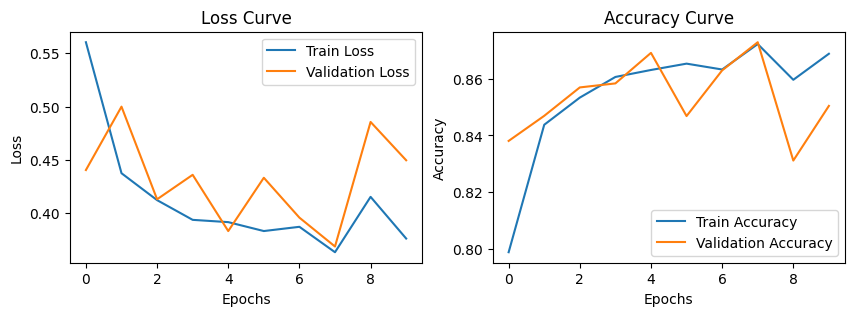


PARAMETERS: batch_size=32, lr=0.001
Epoch [1/10]: Train Loss: 0.5669, Val Loss: 0.3738, Train Accuracy: 0.7913, Val Accuracy: 0.8651.
Epoch [2/10]: Train Loss: 0.3662, Val Loss: 0.3299, Train Accuracy: 0.8666, Val Accuracy: 0.8808.
Epoch [3/10]: Train Loss: 0.3170, Val Loss: 0.3191, Train Accuracy: 0.8829, Val Accuracy: 0.8815.
Epoch [4/10]: Train Loss: 0.2848, Val Loss: 0.2893, Train Accuracy: 0.8957, Val Accuracy: 0.8945.
Epoch [5/10]: Train Loss: 0.2647, Val Loss: 0.2769, Train Accuracy: 0.9019, Val Accuracy: 0.8983.
Epoch [6/10]: Train Loss: 0.2452, Val Loss: 0.2783, Train Accuracy: 0.9089, Val Accuracy: 0.8986.
Epoch [7/10]: Train Loss: 0.2303, Val Loss: 0.2702, Train Accuracy: 0.9145, Val Accuracy: 0.9020.
Epoch [8/10]: Train Loss: 0.2172, Val Loss: 0.2723, Train Accuracy: 0.9186, Val Accuracy: 0.9031.
Epoch [9/10]: Train Loss: 0.2035, Val Loss: 0.2678, Train Accuracy: 0.9232, Val Accuracy: 0.9042.
Epoch [10/10]: Train Loss: 0.1930, Val Loss: 0.2721, Train Accuracy: 0.9277, Val 

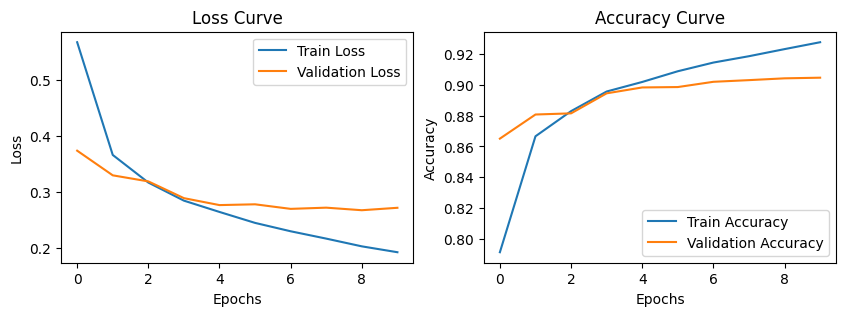


PARAMETERS: batch_size=64, lr=0.01
Epoch [1/10]: Train Loss: 0.5326, Val Loss: 0.3910, Train Accuracy: 0.8023, Val Accuracy: 0.8598.
Epoch [2/10]: Train Loss: 0.3873, Val Loss: 0.3888, Train Accuracy: 0.8594, Val Accuracy: 0.8626.
Epoch [3/10]: Train Loss: 0.3700, Val Loss: 0.3981, Train Accuracy: 0.8662, Val Accuracy: 0.8545.
Epoch [4/10]: Train Loss: 0.3526, Val Loss: 0.3944, Train Accuracy: 0.8719, Val Accuracy: 0.8687.
Epoch [5/10]: Train Loss: 0.3341, Val Loss: 0.3927, Train Accuracy: 0.8791, Val Accuracy: 0.8654.
Epoch [6/10]: Train Loss: 0.3280, Val Loss: 0.3710, Train Accuracy: 0.8829, Val Accuracy: 0.8652.
Epoch [7/10]: Train Loss: 0.3272, Val Loss: 0.4326, Train Accuracy: 0.8817, Val Accuracy: 0.8608.


In [ ]:
criterion = nn.CrossEntropyLoss()

for batch_size in [32, 64]:
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  for lr in [0.01, 0.001]:
    print(f"PARAMETERS: batch_size={batch_size}, lr={lr}")
    model = LeNet()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(params["epochs"]):
      train_loss, train_accuracy = train(model, device)
      val_loss, val_accuracy = validate(model, device)

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f"Epoch [{epoch+1}/{params['epochs']}]: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f},", \
            f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}.")

    plot()
    print()

## Висновок

В ході виконання роботи було завантажено, передоброблено та розділено датасет FashionMNIST на тренувальну, валідаційну та тестову вибірки, реалізовано архітектуру згорткової нейронної мережі LeNet5. Було навчено мережу на завантаженому датасеті з використанням різних гіперпараметрів та побудовано графіки навчання мережі.

Проаналізувавши графіки loss та accuracy для різних параметрів, можна зробити висновок, що найкраще мережа працює при застосуванні параметрів batch_size=64 та lr=0.001.